In [1]:
# Core Library modules
import os  # Operating system interactions, such as reading and writing files.
import shutil  # High-level file operations like copying and moving files.
import random  # Random number generation for various tasks.
import textwrap  # Formatting text into paragraphs of a specified width.
import warnings  # Warning control context manager.
import zipfile  # Work with ZIP archives.
import platform  # Access to underlying platform’s identifying data.
import itertools  # Functions creating iterators for efficient looping.
from dataclasses import dataclass, field  # Class decorator for adding special methods to classes.

# PyTorch and Deep Learning Libaries
import torch  # Core PyTorch library for tensor computations.
import torch.nn as nn  # Neural network module for defining layers and architectures.
from torch.nn import functional as F  # Functional module for defining functions and loss functions.
import torch.optim as optim  # Optimizer module for training models (SGD, Adam, etc.).
from torch.utils.data import Dataset, DataLoader, Subset, random_split  # Data handling and batching
import torchvision  # PyTorch's computer vision library.
from torchvision import datasets, transforms  # Image datasets and transformations.
import torchvision.datasets as datasets  # Specific datasets for vision tasks.
import torchvision.transforms as transforms  # Transformations for image preprocessing.
from torchvision.utils import make_grid  # Grid for displaying images.
import torchvision.models as models  # Pretrained models for transfer learning.
from torchvision.datasets import MNIST, EuroSAT  # Standard datasets.
import torchvision.transforms.functional as TF  # Functional transformations.
from torchvision.models import ResNet18_Weights  # ResNet-18 model with pretrained weights.
from torchsummary import summary  # Model summary.
import torchmetrics  # Model evaluation metrics.
from torchmetrics import MeanMetric, Accuracy  # Accuracy metrics.
from torchmetrics.classification import (
    MultilabelF1Score, MultilabelRecall, MultilabelPrecision, MultilabelAccuracy
)  # Classification metrics.
from torchviz import make_dot  # Model visualization.
from torchvision.ops import sigmoid_focal_loss  # Focal loss for class imbalance.
from torchcam.methods import GradCAM  # Grad-CAM for model interpretability.
from torchcam.utils import overlay_mask  # Overlay mask for visualizations.
import pytorch_lightning as pl  # Training management.
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping, Callback  # Callbacks.
from pytorch_lightning.loggers import TensorBoardLogger  # Logger for TensorBoard.

# Geospatial Data Processing Libraries
import rasterio  # Reading and writing geospatial raster data.
from rasterio.warp import calculate_default_transform, reproject  # Reprojection and transformation.
from rasterio.enums import Resampling  # Resampling for raster resizing.
from rasterio.plot import show  # Visualization of raster data.

# Data Manipulation, Analysis and Visualization Libraries
import pandas as pd  # Data analysis and manipulation.
import numpy as np  # Array operations and computations.
from sklearn.metrics import confusion_matrix, accuracy_score  # Evaluation metrics.
import matplotlib.pyplot as plt  # Static and interactive plotting.
import seaborn as sns  # High-level interface for statistical graphics.

# Utility Libraries
from tqdm import tqdm  # Progress bar for loops.
from PIL import Image  # Image handling and manipulation.
import ast  # Parsing Python code.
import requests  # HTTP requests.
import zstandard as zstd  # Compression and decompression.
from collections import Counter  # Counting hashable objects.
import certifi  # Certificates for HTTPS.
import ssl  # Secure connections.
import urllib.request  # URL handling.
import kaggle  # Kaggle API for datasets.
from IPython.display import Image  # Display images in notebooks.
from pathlib import Path # File system path handling.
from typing import Dict, List, Tuple  # Type hints.
import sys  # System-specific parameters and functions.
import time # Time access and conversions.
import logging # Logging facility for Python.
import json # JSON encoder and decoder.
# Custom Libraries

In [2]:
# Set seed for reproducibility
SEED = 42  
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.set_float32_matmul_precision('medium')

# Set environment variables
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "upb"


# Render plots
%matplotlib inline
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device} {'(GPU: ' + torch.cuda.get_device_name(0) + ')' if device.type == 'cuda' else ''}")

Device: cuda (GPU: NVIDIA GeForce RTX 3050)


In [3]:
def clean_and_parse_labels(label_string):
    if isinstance(label_string, str):
        cleaned_labels = label_string.replace(" '", ", '").replace("[", "[").replace("]", "]")
        return ast.literal_eval(cleaned_labels)
    return label_string  # If it's already a list, return it as is

def calculate_class_weights(metadata_csv):
    metadata_csv['labels'] = metadata_csv['labels'].apply(clean_and_parse_labels)

    class_labels = set()
    for labels in metadata_csv['labels']:
        class_labels.update(labels)

    label_counts = metadata_csv['labels'].explode().value_counts()
    total_counts = label_counts.sum()
    class_weights = {label: total_counts / count for label, count in label_counts.items()}
    class_weights_array = np.array([class_weights[label] for label in class_labels])

    return class_weights, class_weights_array

def calculate_class_labels(metadata_csv):
    metadata_csv['labels'] = metadata_csv['labels'].apply(clean_and_parse_labels)

    class_labels = set()
    for labels in metadata_csv['labels']:
        class_labels.update(labels)

    return class_labels

In [4]:
class BandNormalisation:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        for i in range(image.shape[0]):
            print(f"Channel {i} - Mean: {self.mean[i]}, Std: {self.std[i]}")
            image[i] = (image[i] - self.mean[i]) / self.std[i]
            print(f"Channel {i} after normalization: {image[i]}")
        return image
    
class BandUnnormalisation:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        for i in range(image.shape[0]):
            image[i] = (image[i] * self.std[i]) + self.mean[i]
        return image

In [5]:
# Description: Configuration file for the project
@dataclass
class DatasetConfig:
    metadata_path = r"C:\\Users\\isaac\\Desktop\BigEarthTests\\50%_BigEarthNet\\metadata_50_percent.csv"
    dataset_paths = {
        "0.5": r"C:\Users\isaac\Desktop\BigEarthTests\0.5%_BigEarthNet\CombinedImages",
        "1": r"C:\Users\isaac\Desktop\BigEarthTests\1%_BigEarthNet\CombinedImages",
        "5": r"C:\Users\isaac\Desktop\BigEarthTests\5%_BigEarthNet\CombinedImages",
        "10": r"C:\Users\isaac\Desktop\BigEarthTests\10%_BigEarthNet\CombinedImages",
        "50": r"C:\Users\isaac\Desktop\BigEarthTests\50%_BigEarthNet\CombinedImages",
        "100": r"C:\Users\isaac\Desktop\BigEarthTests\100%_BigEarthNet\CombinedImages"
    }
    metadata_paths = {
        "0.5": r"C:\Users\isaac\Desktop\BigEarthTests\0.5%_BigEarthNet\metadata_0.5_percent.csv",
        "1": r"C:\Users\isaac\Desktop\BigEarthTests\1%_BigEarthNet\metadata_1_percent.csv",
        "5": r"C:\Users\isaac\Desktop\BigEarthTests\5%_BigEarthNet\metadata_5_percent.csv",
        "10": r"C:\Users\isaac\Desktop\BigEarthTests\10%_BigEarthNet\metadata_10_percent.csv",
        "50": r"C:\Users\isaac\Desktop\BigEarthTests\50%_BigEarthNet\metadata_50_percent.csv",
        "100": r"C:\Users\isaac\Desktop\BigEarthTests\100%_BigEarthNet\metadata_100_percent.csv"
    }
    unwanted_metadata_file: str = r'C:\Users\isaac\Downloads\metadata_for_patches_with_snow_cloud_or_shadow.parquet'
    unwanted_metadata_csv = pd.read_parquet(unwanted_metadata_file)

    class_labels = calculate_class_labels(pd.read_csv(metadata_path))
    class_labels = class_labels
    class_labels_dict = {label: idx for idx, label in enumerate(class_labels)}
    reversed_class_labels_dict = {idx: label for label, idx in class_labels_dict.items()}

    num_classes: int = 19
    band_channels: int = 12
    valid_pct: float = 0.1
    img_size: int = 120

    rgb_bands = ["B04", "B03", "B02"]
    rgb_nir_bands = ["B04", "B03", "B02", "B08"]
    rgb_swir_bands = ["B04", "B03", "B02", "B11", "B12"]
    rgb_nir_swir_bands = ["B04", "B03", "B02", "B08", "B11", "B12"]
    all_imp_bands = [ "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
    all_bands = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"]
    
    band_stats = {
        "mean": {
            "B01": 359.93681858037576,
            "B02": 437.7795146920668,
            "B03": 626.9061237185847,
            "B04": 605.0589129818594,
            "B05": 971.6512098450492,
            "B06": 1821.9817358749056,
            "B07": 2108.096240315571,
            "B08": 2256.3215618504346,
            "B8A": 2310.6351913265307,
            "B09": 2311.6085833217353,
            "B11": 1608.6865167942176,
            "B12": 1017.1259618291762
        },
        "std": {
            "B01": 583.5085769396974,
            "B02": 648.4384481402268,
            "B03": 639.2669907766995,
            "B04": 717.5748664544205,
            "B05": 761.8971822905785,
            "B06": 1090.758232889144,
            "B07": 1256.5524552734478,
            "B08": 1349.2050493390414,
            "B8A": 1287.1124261320342,
            "B09": 1297.654379610044,
            "B11": 1057.3350765979644,
            "B12": 802.1790763840752
        }
    }

@dataclass
class ModelConfig:
    num_epochs: int = 10
    batch_size: int = 32
    num_workers: int = os.cpu_count() // 2
    learning_rate: float = 0.0001
    momentum: float = 0.9
    weight_decay: float = 1e-4
    lr_step_size: int = 7
    lr_factor: float = 0.1
    patience: int = 5
    lr_patience: int = 5
    dropout: float = 0.5

    model_names: list = field(default_factory=lambda: [
        'resnet18', 
        'resnet34', 
        'resnet50', 
        'resnet101', 
        'resnet152', 
        'densenet121', 
        'densenet169', 
        'densenet201', 
        'densenet161',
        'efficientnet-b0',
        'vgg16',
        'vgg19'
    ])

@dataclass
class ModuleConfig:
    reduction: int = 16
    ratio: int = 8
    kernel_size: int = 3
    dropout_rt: float = 0.1
    activation: type = nn.ReLU

@dataclass
class TransformsConfig:
    train_transforms = transforms.Compose([
        BandNormalisation(
            mean=[DatasetConfig.band_stats["mean"][band] for band in DatasetConfig.all_bands],
            std=[DatasetConfig.band_stats["std"][band] for band in DatasetConfig.all_bands]
        )
    ])

    val_transforms = transforms.Compose([
        transforms.CenterCrop(120),
        BandNormalisation(
            mean=[DatasetConfig.band_stats["mean"][band] for band in DatasetConfig.all_bands],
            std=[DatasetConfig.band_stats["std"][band] for band in DatasetConfig.all_bands]
        )
    ])

    test_transforms = transforms.Compose([
        transforms.CenterCrop(120),
        BandNormalisation(
            mean=[DatasetConfig.band_stats["mean"][band] for band in DatasetConfig.all_bands],
            std=[DatasetConfig.band_stats["std"][band] for band in DatasetConfig.all_bands]
        )
    ])



In [8]:
print(DatasetConfig.class_labels_dict)
print(DatasetConfig.reversed_class_labels_dict)

{'Coastal wetlands': 0, 'Inland wetlands': 1, 'Industrial or commercial units': 2, 'Urban fabric': 3, 'Arable land': 4, 'Transitional woodland, shrub': 5, 'Complex cultivation patterns': 6, 'Agro-forestry areas': 7, 'Mixed forest': 8, 'Pastures': 9, 'Broad-leaved forest': 10, 'Marine waters': 11, 'Permanent crops': 12, 'Inland waters': 13, 'Moors, heathland and sclerophyllous vegetation': 14, 'Land principally occupied by agriculture, with significant areas of natural vegetation': 15, 'Coniferous forest': 16, 'Beaches, dunes, sands': 17, 'Natural grassland and sparsely vegetated areas': 18}
{0: 'Coastal wetlands', 1: 'Inland wetlands', 2: 'Industrial or commercial units', 3: 'Urban fabric', 4: 'Arable land', 5: 'Transitional woodland, shrub', 6: 'Complex cultivation patterns', 7: 'Agro-forestry areas', 8: 'Mixed forest', 9: 'Pastures', 10: 'Broad-leaved forest', 11: 'Marine waters', 12: 'Permanent crops', 13: 'Inland waters', 14: 'Moors, heathland and sclerophyllous vegetation', 15: 'L

In [9]:
def encode_label(label: list, num_classes=DatasetConfig.num_classes):
    target = torch.zeros(num_classes)
    for l in label:
        if l in DatasetConfig.class_labels_dict:
            target[DatasetConfig.class_labels_dict[l]] = 1.0
    return target

def decode_target(
    target: list,
    text_labels: bool = False,
    threshold: float = 0.4,
    cls_labels: dict = None,
):
    result = []
    for i, x in enumerate(target):
        if x >= threshold:
            if text_labels:
                result.append(cls_labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return " ".join(result)


def get_band_indices(band_names, all_band_names):
    return [all_band_names.index(band) for band in band_names]


In [11]:
class BigEarthNetDatasetTIF(Dataset):
    def __init__(self, *, df, root_dir, transforms=None, is_test=False, selected_bands=None, metadata_csv=None):
        self.df = df
        self.root_dir = root_dir
        self.transforms = transforms
        self.is_test = is_test
        self.selected_bands = selected_bands if selected_bands is not None else DatasetConfig.rgb_bands
        self.metadata = metadata_csv

        self.image_paths = list(Path(root_dir).rglob("*.tif"))
        self.patch_to_labels = dict(zip(self.metadata['patch_id'], self.metadata['labels']))
        self.image_paths = list(Path(root_dir).rglob("*.tif"))

        self.selected_band_indices = get_band_indices(self.selected_bands, DatasetConfig.all_bands)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        with rasterio.open(image_path) as src:
            image = src.read()  
            image = image[self.selected_band_indices, :, :]
        
        # Image is convered to a tensor before applying transforms
        image = torch.tensor(image, dtype=torch.float32)

        if self.transforms:
            image = self.transforms(image)

        label = self.get_label(image_path)

        return image, label

    def get_label(self, img_path):
        img_path = Path(img_path) 
        patch_id = img_path.stem
        labels = self.patch_to_labels.get(patch_id, None)

        if labels is None:
            return torch.zeros(DatasetConfig.num_classes)  
    
        if isinstance(labels, str):
            cleaned_labels = labels.replace(" '", ", '").replace("[", "[").replace("]", "]")
            labels =  ast.literal_eval(cleaned_labels)
        
        encoded = encode_label(labels)
        return encoded
    

In [12]:
metadata_csv_path = DatasetConfig.metadata_paths['0.5']

metadata_csv = pd.read_csv(metadata_csv_path)

# Filter the DataFrame for the 'train' split
train_df = metadata_csv[metadata_csv['split'] == 'train']

# Create the dataset
train_dataset = BigEarthNetDatasetTIF(df=train_df, root_dir=DatasetConfig.dataset_paths['0.5'], transforms=TransformsConfig.train_transforms, selected_bands=DatasetConfig.all_bands, metadata_csv=metadata_csv)
train_dataset_no_transforms = BigEarthNetDatasetTIF(df=train_df, root_dir=DatasetConfig.dataset_paths['0.5'], transforms=None, selected_bands=DatasetConfig.all_bands, metadata_csv=metadata_csv)
print(f"Dataset length: {len(train_dataset)}")

Dataset length: 1140


In [13]:
image, label = train_dataset[5]
image2, label2 = train_dataset_no_transforms[5]
print(f"Image shape: {image.size}, Label: {label}")
print(f"Image shape: {image2.size}, Label: {label2}")

Channel 0 - Mean: 359.93681858037576, Std: 583.5085769396974
Channel 0 after normalization: tensor([[-0.3049, -0.3049, -0.3049,  ..., -0.3529, -0.3529, -0.3529],
        [-0.3049, -0.3049, -0.3049,  ..., -0.3529, -0.3529, -0.3529],
        [-0.3049, -0.3049, -0.3049,  ..., -0.3529, -0.3529, -0.3529],
        ...,
        [ 0.1509,  0.1509,  0.1509,  ..., -0.4009, -0.4009, -0.4009],
        [ 0.1509,  0.1509,  0.1509,  ..., -0.4009, -0.4009, -0.4009],
        [ 0.1509,  0.1509,  0.1509,  ..., -0.4009, -0.4009, -0.4009]])
Channel 1 - Mean: 437.7795146920668, Std: 648.4384481402268
Channel 1 after normalization: tensor([[-0.4238, -0.4191, -0.4546,  ..., -0.4932, -0.4469, -0.4469],
        [-0.3806, -0.3605, -0.3991,  ..., -0.4037, -0.4160, -0.4361],
        [-0.4361, -0.4253, -0.3713,  ..., -0.2958, -0.3389, -0.3883],
        ...,
        [ 0.3180,  0.0990,  0.1006,  ..., -0.4870, -0.4222, -0.4207],
        [ 0.4892,  0.4846,  0.1499,  ..., -0.4746, -0.4546, -0.5024],
        [-0.1323,  0

In [14]:
print(train_dataset)
print(train_dataset_no_transforms)

In [15]:
print("Normalised image")
print("Image shape:", image.shape)
print(image)

print("Unnormalised image")
print("Image shape:", image2.shape)
print(image2)

Normalised image
Image shape: torch.Size([12, 120, 120])
tensor([[[-0.3049, -0.3049, -0.3049,  ..., -0.3529, -0.3529, -0.3529],
         [-0.3049, -0.3049, -0.3049,  ..., -0.3529, -0.3529, -0.3529],
         [-0.3049, -0.3049, -0.3049,  ..., -0.3529, -0.3529, -0.3529],
         ...,
         [ 0.1509,  0.1509,  0.1509,  ..., -0.4009, -0.4009, -0.4009],
         [ 0.1509,  0.1509,  0.1509,  ..., -0.4009, -0.4009, -0.4009],
         [ 0.1509,  0.1509,  0.1509,  ..., -0.4009, -0.4009, -0.4009]],

        [[-0.4238, -0.4191, -0.4546,  ..., -0.4932, -0.4469, -0.4469],
         [-0.3806, -0.3605, -0.3991,  ..., -0.4037, -0.4160, -0.4361],
         [-0.4361, -0.4253, -0.3713,  ..., -0.2958, -0.3389, -0.3883],
         ...,
         [ 0.3180,  0.0990,  0.1006,  ..., -0.4870, -0.4222, -0.4207],
         [ 0.4892,  0.4846,  0.1499,  ..., -0.4746, -0.4546, -0.5024],
         [-0.1323,  0.4969,  0.4892,  ..., -0.5332, -0.4639, -0.5132]],

        [[-0.4441, -0.3862, -0.3862,  ..., -0.4160, -0.4191

In [16]:
class BigEarthNetTIFDataModule(pl.LightningDataModule):
    def __init__(self, bands=None, dataset_dir=None, metadata_csv=None):
        super().__init__()
        self.bands = bands
        self.dataset_dir = dataset_dir
        self.metadata_csv = metadata_csv

    def setup(self, stage=None):
        train_df = self.metadata_csv[self.metadata_csv['split'] == 'train']
        val_df = self.metadata_csv[self.metadata_csv['split'] == 'validation']
        test_df = self.metadata_csv[self.metadata_csv['split'] == 'test']

        self.train_dataset = BigEarthNetDatasetTIF(df=train_df, root_dir=self.dataset_dir, transforms=TransformsConfig.train_transforms, selected_bands=self.bands, metadata_csv=self.metadata_csv)
        self.val_dataset = BigEarthNetDatasetTIF(df=val_df, root_dir=self.dataset_dir, transforms=TransformsConfig.val_transforms, selected_bands=self.bands, metadata_csv=self.metadata_csv)
        self.test_dataset = BigEarthNetDatasetTIF(df=test_df, root_dir=self.dataset_dir, transforms=TransformsConfig.test_transforms, selected_bands=self.bands, metadata_csv=self.metadata_csv)
        
    def train_dataloader(self):
        dataloader = DataLoader(self.train_dataset, batch_size=ModelConfig.batch_size, num_workers=ModelConfig.num_workers, pin_memory=True, shuffle=True, persistent_workers=True)
        return dataloader

    def val_dataloader(self):
        dataloader = DataLoader(self.val_dataset, batch_size=ModelConfig.batch_size,  num_workers=ModelConfig.num_workers, pin_memory=True,  persistent_workers=True)
        return dataloader

    def test_dataloader(self):
        dataloader = DataLoader(self.test_dataset, batch_size=ModelConfig.batch_size,  num_workers=ModelConfig.num_workers, pin_memory=True,  persistent_workers=True)
        return dataloader

In [17]:
# Initialize the data module
data_module = BigEarthNetTIFDataModule(bands=DatasetConfig.all_bands, dataset_dir=DatasetConfig.dataset_paths['0.5'], metadata_csv=metadata_csv)
data_module.setup(stage=None)

metadata_csv = pd.read_csv(DatasetConfig.metadata_paths['0.5'])
valid_df = metadata_csv[metadata_csv['split'] == 'validation']

valid_dataset = BigEarthNetDatasetTIF(df=valid_df, root_dir=DatasetConfig.dataset_paths['0.5'], transforms=TransformsConfig.train_transforms, selected_bands=DatasetConfig.all_bands, metadata_csv=metadata_csv)
print(f"Dataset length: {len(valid_dataset)}")

Dataset length: 594


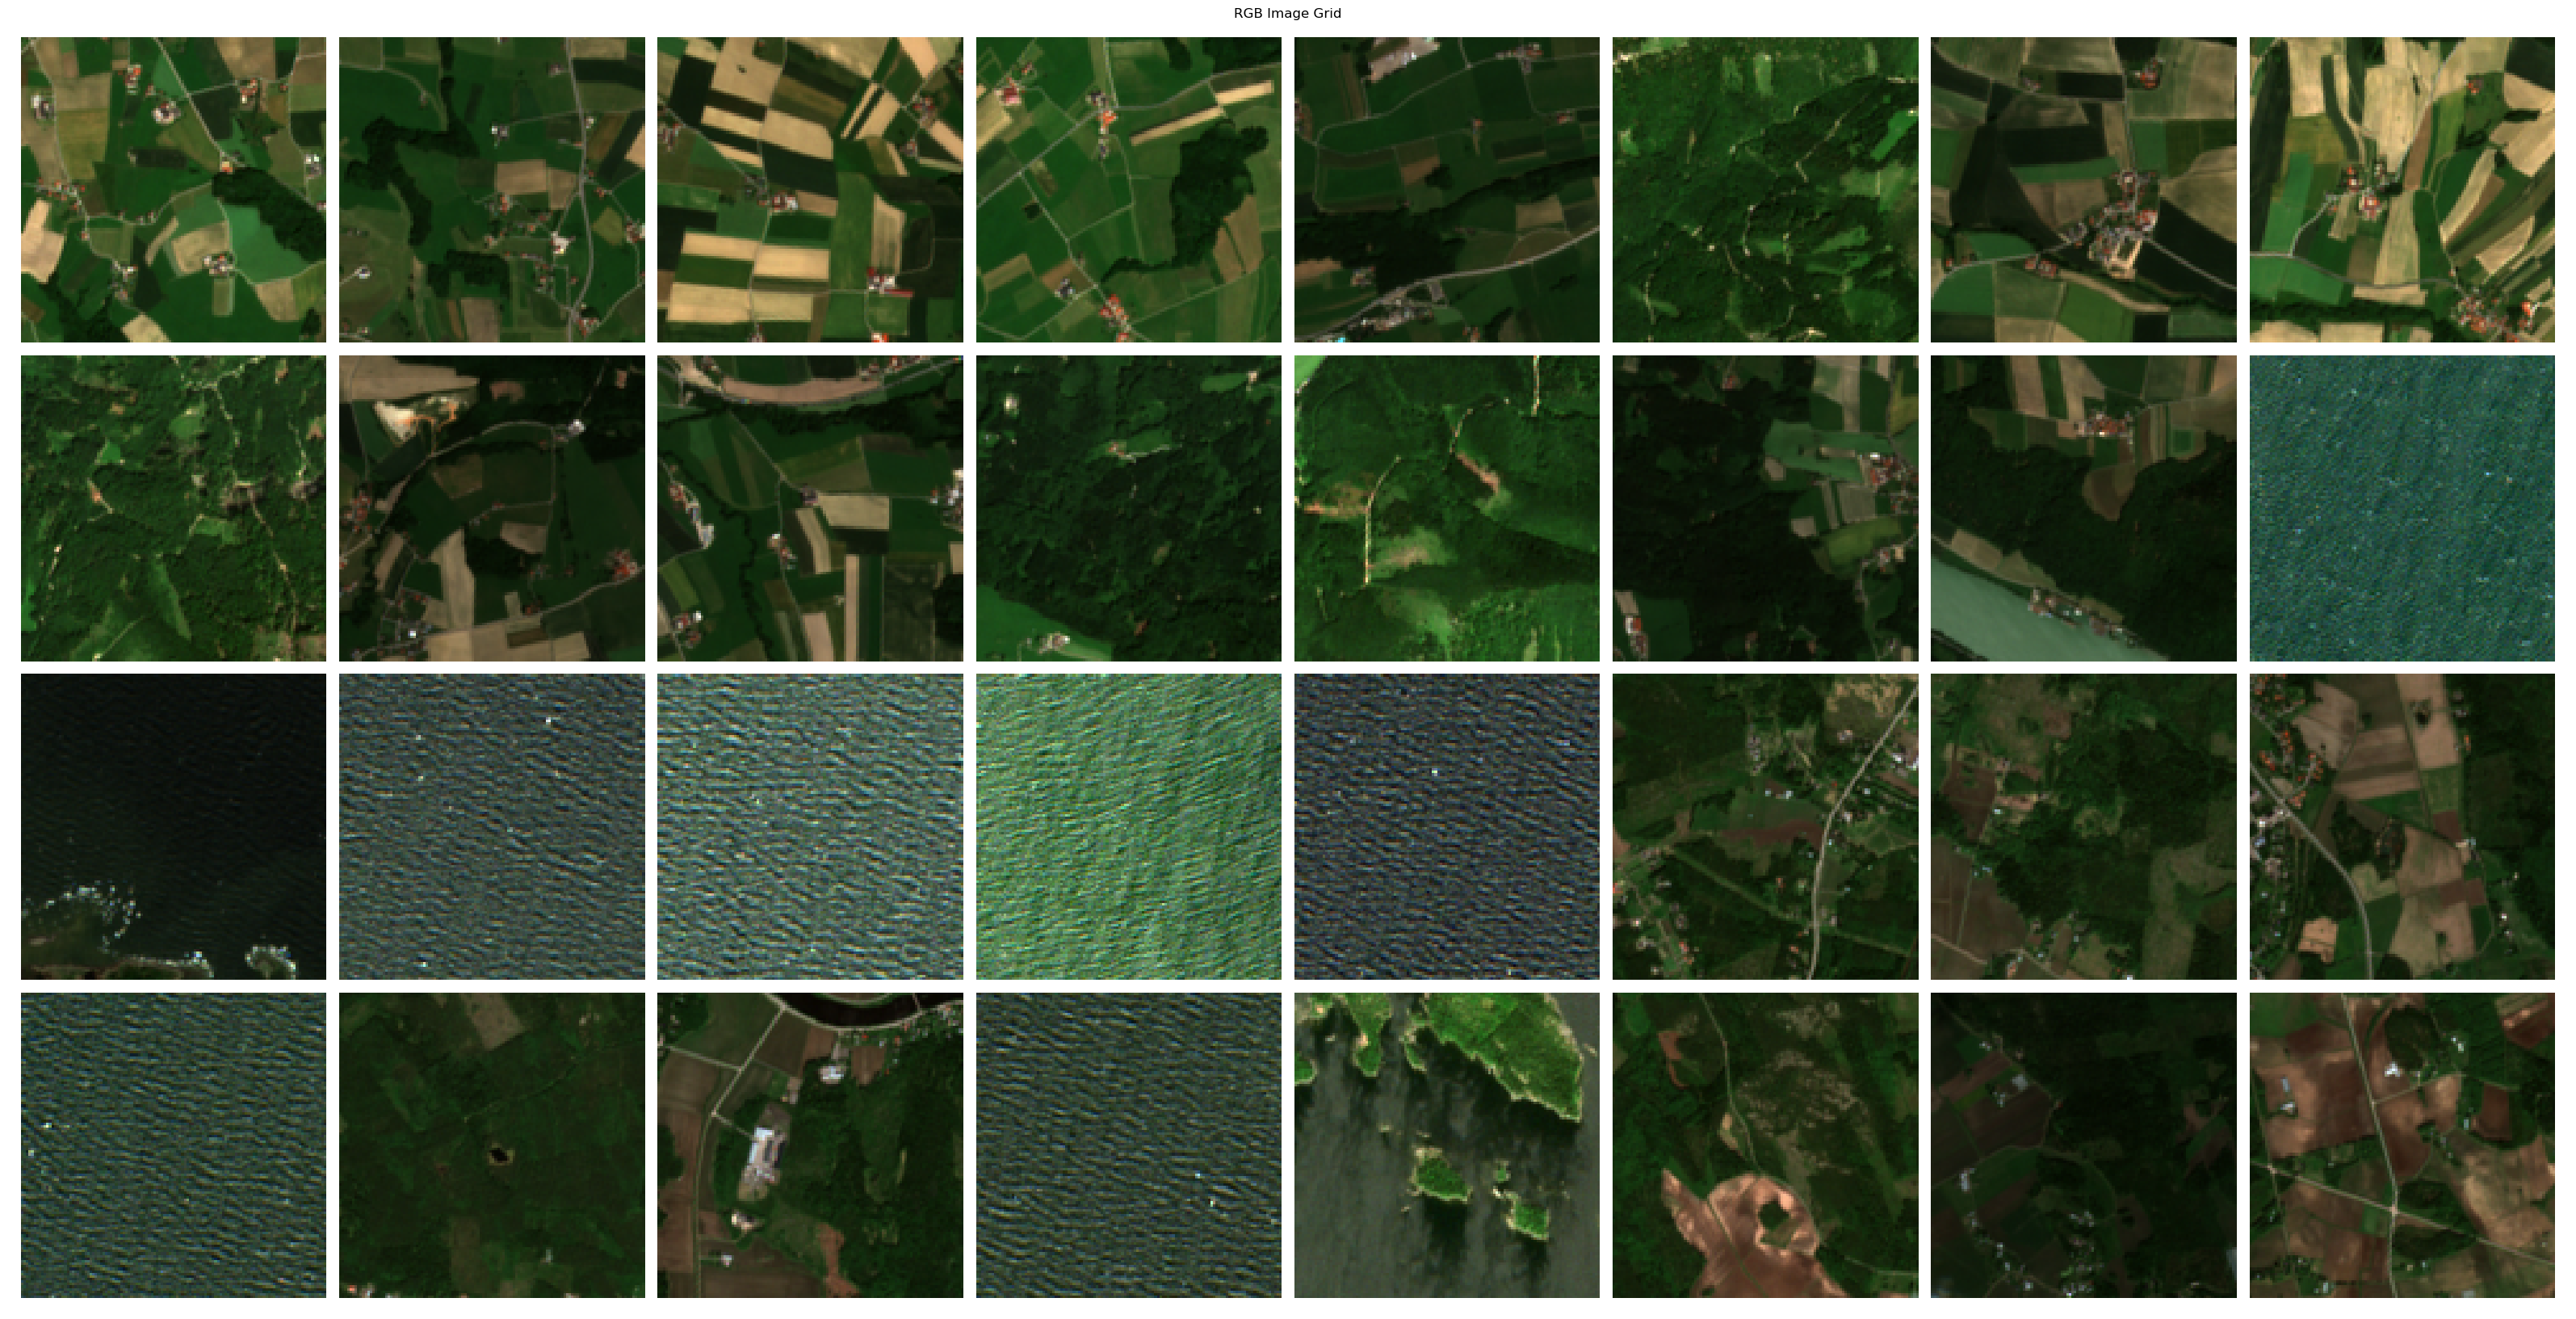

In [56]:
def display_rgb_from_batch(batch):
    images = batch[0] 
    
    # Normalize each channel to the range [0, 1]
    images = images.float()
    for idx in range(images.size(0)):
        image = images[idx]
        image -= image.min()
        image /= image.max()
    
    grid_img = make_grid(images, nrow=8, padding=5, pad_value=1.0)
    grid_img = grid_img.permute(1, 2, 0).numpy()
    
    # Display the grid of RGB images
    plt.figure(figsize=(32, 32))
    plt.imshow(grid_img)
    plt.title('RGB Image Grid')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the images in the batch as a grid
display_rgb_from_batch(batch)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class BigEarthNetResNet18ModelTIF(pl.LightningModule):
    def __init__(self):
        super(BigEarthNetResNet18ModelTIF, self).__init__()
        # Load the ResNet-18 model
        self.model = models.resnet18(weights=None)

        original_conv1 = self.model.conv1
        self.model.conv1 = nn.Conv2d(
            in_channels=3,  
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=original_conv1.bias,
        )

        # Initialize weights for the new channels (copy pretrained weights for 3 channels and random for the rest)
        nn.init.kaiming_normal_(self.model.conv1.weight, mode='fan_out', nonlinearity='relu')

        # Modify the final layer to output 19 classes
        self.model.fc = nn.Linear(self.model.fc.in_features, DatasetConfig.num_classes)
        # Addition of a sigmoid activation function for muylti-label classification
        self.sigmoid = nn.Sigmoid()
        # Passing the model to the GPU
        self.model.to(device)

        # Accuracy metrics
        self.train_acc = MultilabelAccuracy(num_labels=DatasetConfig.num_classes)
        self.val_acc = MultilabelAccuracy(num_labels=DatasetConfig.num_classes)
        self.test_acc = MultilabelAccuracy(num_labels=DatasetConfig.num_classes)

        # Recall metrics
        self.train_recall = MultilabelRecall(num_labels=DatasetConfig.num_classes)
        self.val_recall = MultilabelRecall(num_labels=DatasetConfig.num_classes)
        self.test_recall = MultilabelRecall(num_labels=DatasetConfig.num_classes)

        # Precision metrics
        self.train_precision = MultilabelPrecision(num_labels=DatasetConfig.num_classes)
        self.val_precision = MultilabelPrecision(num_labels=DatasetConfig.num_classes)
        self.test_precision = MultilabelPrecision(num_labels=DatasetConfig.num_classes)

        # F1 Score metrics
        self.train_f1 = MultilabelF1Score(num_labels=DatasetConfig.num_classes)
        self.val_f1 = MultilabelF1Score(num_labels=DatasetConfig.num_classes)
        self.test_f1 = MultilabelF1Score(num_labels=DatasetConfig.num_classes)

        #torch.summary(self.model, (DatasetConfig.band_channels, ModelConfig.img_size, ModelConfig.img_size))

    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x
    
    def cross_entropy_loss(self, logits, labels):
        return F.binary_cross_entropy_with_logits(logits, labels)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        acc = self.train_acc(logits, y)
        recall = self.train_recall(logits, y)
        f1 = self.train_f1(logits, y)
        precision = self.train_precision(logits, y)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_precision', precision, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        acc = self.val_acc(logits, y)
        recall = self.val_recall(logits, y)
        f1 = self.val_f1(logits, y)
        precision = self.val_precision(logits, y)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        self.log('val_recall', recall, on_epoch=True, prog_bar=True)
        self.log('val_f1', f1, on_epoch=True, prog_bar=True)
        self.log('val_precision', precision, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        acc = self.test_acc(logits, y)
        recall = self.test_recall(logits, y)
        f1 = self.test_f1(logits, y)
        precision = self.test_precision(logits, y)

        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_acc', acc, on_epoch=True, prog_bar=True)
        self.log('test_recall', recall, on_epoch=True, prog_bar=True)
        self.log('test_f1', f1, on_epoch=True, prog_bar=True)
        self.log('test_precision', precision, on_epoch=True, prog_bar=True)
        
        return loss
    
    def on_train_epoch_end(self):
        self.log('train_acc_epoch', self.train_acc.compute())
        self.log('train_recall_epoch', self.train_recall.compute())
        self.log('train_f1_epoch', self.train_f1.compute())
        self.log('train_precision_epoch', self.train_precision.compute())

    def on_validation_epoch_end(self):
        self.log('val_acc_epoch', self.val_acc.compute())
        self.log('val_recall_epoch', self.val_recall.compute())
        self.log('val_f1_epoch', self.val_f1.compute())
        self.log('val_precision_epoch', self.val_precision.compute())
    
    def on_test_epoch_end(self):
        self.log('test_acc_epoch', self.test_acc.compute())
        self.log('test_recall_epoch', self.test_recall.compute())
        self.log('test_f1_epoch', self.test_f1.compute())
        self.log('test_precision_epoch', self.test_precision.compute())

In [ ]:
data_module = BigEarthNetTIFDataModule()
data_module.setup()

model = BigEarthNetResNet18ModelTIF()

# Initialize the logger
log_dir = r'C:\Users\isaac\OneDrive\Documents\GitHub\Deep-Learning-Based-Land-Use-Classification-Using-Sentinel-2-Imagery\FYPProjectMultiSpectral\experiments\logs'
logger = TensorBoardLogger(log_dir, name=f"my_model_resnet18_eurosat_notpretrained")

weights_info = 'none'
checkpoint_dir = r'C:\Users\isaac\OneDrive\Documents\GitHub\Deep-Learning-Based-Land-Use-Classification-Using-Sentinel-2-Imagery\FYPProjectMultiSpectral\experiments\checkpoints'
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename=f'resnet18-{weights_info}-{{epoch:02d}}-{{val_loss:.2f}}',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

# Model Training with custom callback
trainer = pl.Trainer(
    default_root_dir=checkpoint_dir,
    max_epochs=ModelConfig.num_epochs,
    logger=logger,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    log_every_n_steps=1,
    callbacks=[checkpoint_callback]
)

# Start training
trainer.fit(model, data_module)

Number of samples in train set: 1195, val set: 606, test set: 551


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | model           | ResNet              | 11.2 M | train
1  | sigmoid         | Sigmoid             | 0      | train
2  | train_acc       | MultilabelAccuracy  | 0      | train
3  | val_acc         | MultilabelAccuracy  | 0      | train
4  | test_acc        | MultilabelAccuracy  | 0      | train
5  | train_recall    | MultilabelRecall    | 0      | train
6  | val_recall      | MultilabelRecall    | 0      | train
7  | test_recall     | MultilabelRecall    | 0      | train
8  | train_precision | MultilabelPrecision | 0      | train
9  | val_precision   | MultilabelPrecision | 0      | train
10 | test_precision  | MultilabelPrecision | 0      | train
11 | train_f1        | MultilabelF1Score   | 0      | t

Number of samples in train set: 1195, val set: 606, test set: 551


Sanity Checking: |          | 0/? [00:00<?, ?it/s]